In [1]:
# Importing necessary modules
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import cv2
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.feature import hog
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

In [2]:
# Downloading the dataset

os.environ['KAGGLE_USERNAME'] = 'samhedley'
os.environ['KAGGLE_KEY'] = 'KGAT_b7cd8b87cb2a0346ef10f-b182f099721'
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria --unzip

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 98% 659M/675M [00:01<00:00, 277MB/s] 
100% 675M/675M [00:01<00:00, 371MB/s]


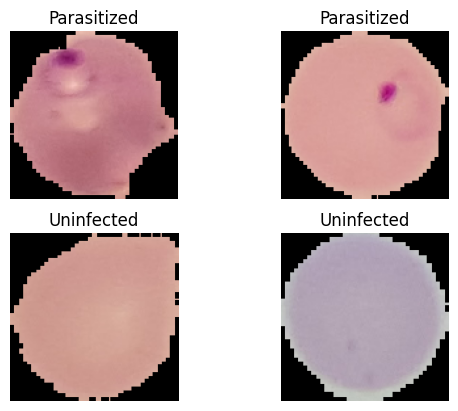

In [3]:
# Visualizing sample images from the dataset

# Setting up directories
data_dir = "./cell_images" # Directory for the dataset

# Directories for the two classes
parasitized_dir = os.path.join(data_dir, 'Parasitized')
uninfected_dir = os.path.join(data_dir, 'Uninfected')

# Sample images to display
parasitized_imgs = os.listdir(parasitized_dir)[:2]
uninfected_imgs = os.listdir(uninfected_dir)[:2]

imgs = parasitized_imgs + uninfected_imgs

# Plotting the images
for i in range(len(imgs)):
    if i < 2: # Selecting only parasitized images for the first half
        img_path = os.path.join(parasitized_dir, imgs[i])
        label = 'Parasitized'
    else: # Selecting uninfected images for the second half
        img_path = os.path.join(uninfected_dir, imgs[i])
        label = 'Uninfected'
    # Load and display the images
    img = image.load_img(img_path, target_size=(128, 128))
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

In [4]:
# Histogram of Oriented Gradients (HOG) Feature Extraction

img_size = 64 # Resizing images to 64x64 for HOG

# Function to extract HOG features
def HOG(folder_path):
    features = [] # List to store HOG features
    labels = [] # List to store labels

    for label in ['Parasitized', 'Uninfected']: # Looping through both classes
        class_dir = os.path.join(folder_path, label) # Directory for the current class
        for img_name in os.listdir(class_dir): # Looping through images in the class directory
            try: # Some files might be corrupted or unreadable, so we use try-except to pass those
                img_path = os.path.join(class_dir, img_name) # Full path to the image
                
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # Read image in grayscale
                img = cv2.resize(img, (img_size, img_size)) # Resize image
                img = img / 255.0 # Normalize pixel values to [0, 1]

                # Extract HOG features
                hog_vector = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
                
                features.append(hog_vector) # Append HOG features to the list
                labels.append(0 if label == 'Parasitized' else 1) # Append label (0 for Parasitized, 1 for Uninfected)

            except:
                pass # Skip unreadable images / files that are not images
            
    return features, labels # Return features and labels

In [5]:
# Extracting HOG features and labels from the dataset
X, y = HOG(data_dir) # X contains HOG features, y contains labels

In [6]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# Training a Linear Support Vector Machine (SVM) Classifier

svm = LinearSVC(C=0.001, max_iter=1000) # Initializing the Linear SVM classifier

svm.fit(X_train, y_train) # Training the SVM classifier

y_pred = svm.predict(X_test) # Predicting labels for the test set

print("Accuracy:", accuracy_score(y_test, y_pred)) # Printing accuracy of the model
print(classification_report(y_test, y_pred)) # Printing classification report

Accuracy: 0.8403483309143687
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      3445
           1       0.83      0.85      0.84      3445

    accuracy                           0.84      6890
   macro avg       0.84      0.84      0.84      6890
weighted avg       0.84      0.84      0.84      6890

